# Projection data 

In [1]:
import xarray as xr
import numpy as np
import rioxarray
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import pandas as pd
import cftime

In [2]:
import func

In [3]:
TempProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/tas_CentralEurope_0.5x0.5degrees_downscaled.nc')
LaiProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/lai_CentralEurope_0.5x0.5degrees_downscaled.nc')
PrecProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/pr_CentralEurope_0.5x0.5degrees_downscaled.nc')
RadProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/rls_CentralEurope_0.5x0.5degrees_downscaled.nc')

# Forcing data

In [4]:
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

# Cropping and interpolating Projections Data

### Precipitation, radiation, lai

In [35]:
def clip_proj_prec(forcing_data, proj_data):
    min_lon = forcing_data.lon.min().values - 0.5
    min_lat = forcing_data.lat.min().values - 0.5
    max_lon = forcing_data.lon.max().values + 0.5
    max_lat = forcing_data.lat.max().values + 0.5
    
    proj_data = proj_data.rio.write_crs('epsg:4326')

    # Clip the projection data
    proj_data_clipped = proj_data.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    
    # Rename dimensions to match the forcing data
    proj_data_interp = proj_data_clipped.rename({'x': 'lon', 'y': 'lat'})
    
    # Interpolate onto the grid of forcing data
    proj_data_interp = proj_data_interp.interp(
        lon=forcing_data.lon,
        lat=forcing_data.lat,
        method='linear'
    )
    
    # Clip interpolated values to be non-negative
    proj_data_interp = proj_data_interp.where(proj_data_interp >= 0, 0)
    
    return proj_data_clipped, proj_data_interp

In [36]:
PrecProj_clipped, PrecProj_interp = clip_proj_prec(P_data, PrecProj)
# func.plot_proj_data(PrecProj_interp, PrecProj_clipped, world)

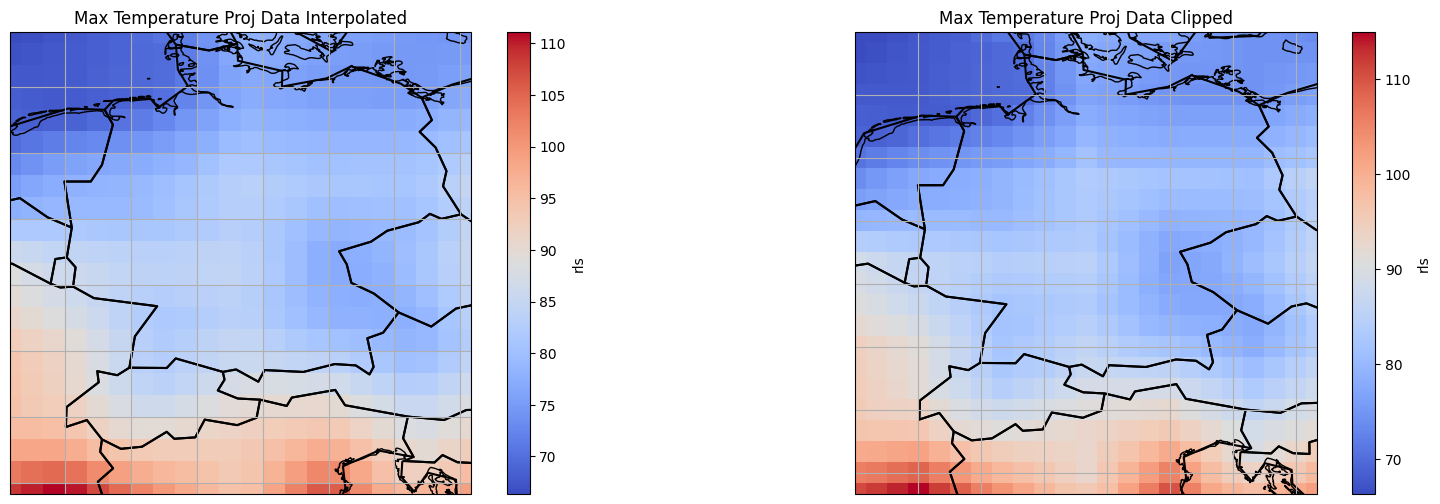

In [262]:
RadProj_clipped, RadProj_interp = func.clip_proj(R_data, RadProj)
func.plot_proj_data(RadProj_interp, RadProj_clipped, world)

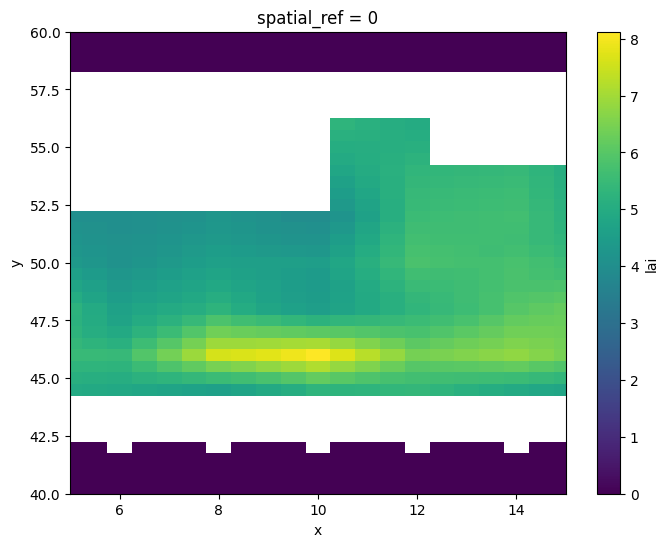

In [228]:
# lai data is incomplete

plt.figure(figsize=(8, 6))
LaiProj.max(dim='time').plot()

# Set the limits for y-axis and x-axis
plt.ylim([40, 60])  # Set the limits for y-axis
plt.xlim([5, 15])  # Set the limits for x-axis

plt.show()

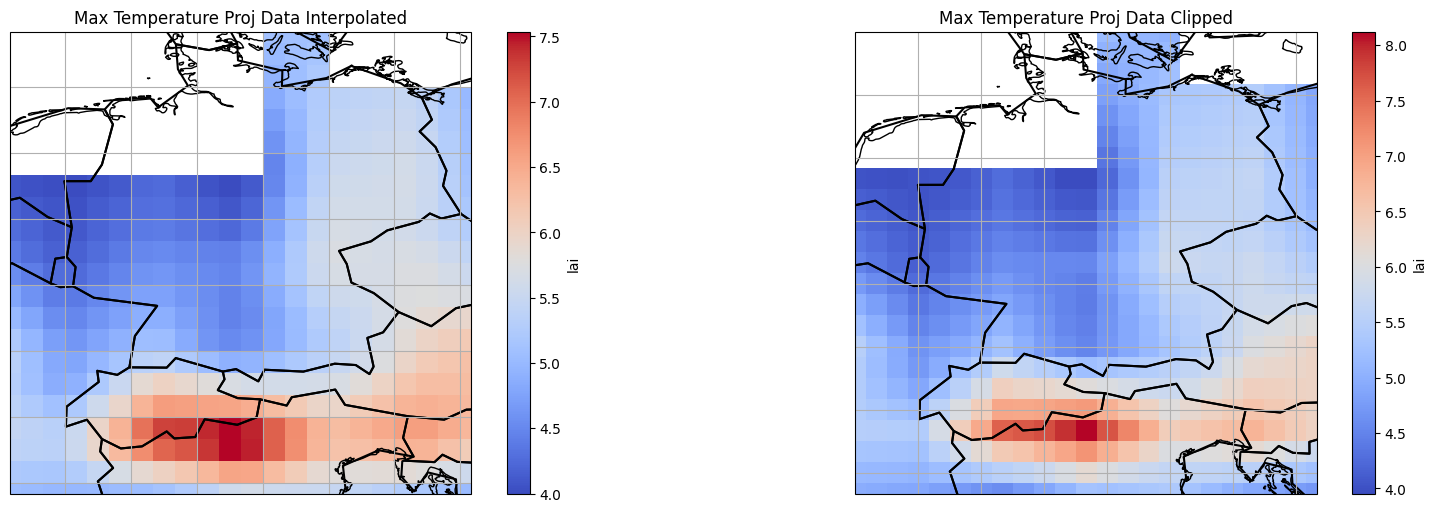

In [226]:
LaiProj_clipped, LaiProj_interp = func.clip_proj(lai_data, LaiProj)
func.plot_proj_data(LaiProj_interp, LaiProj_clipped, world)

### Temperature (long version)

In [166]:
min_lon = T_data.lon.min().values - 0.5
min_lat = T_data.lat.min().values - 0.5
max_lon = T_data.lon.max().values + 0.5
max_lat = T_data.lat.max().values + 0.5

In [167]:
TempProj_clipped = TempProj.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1394009193.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


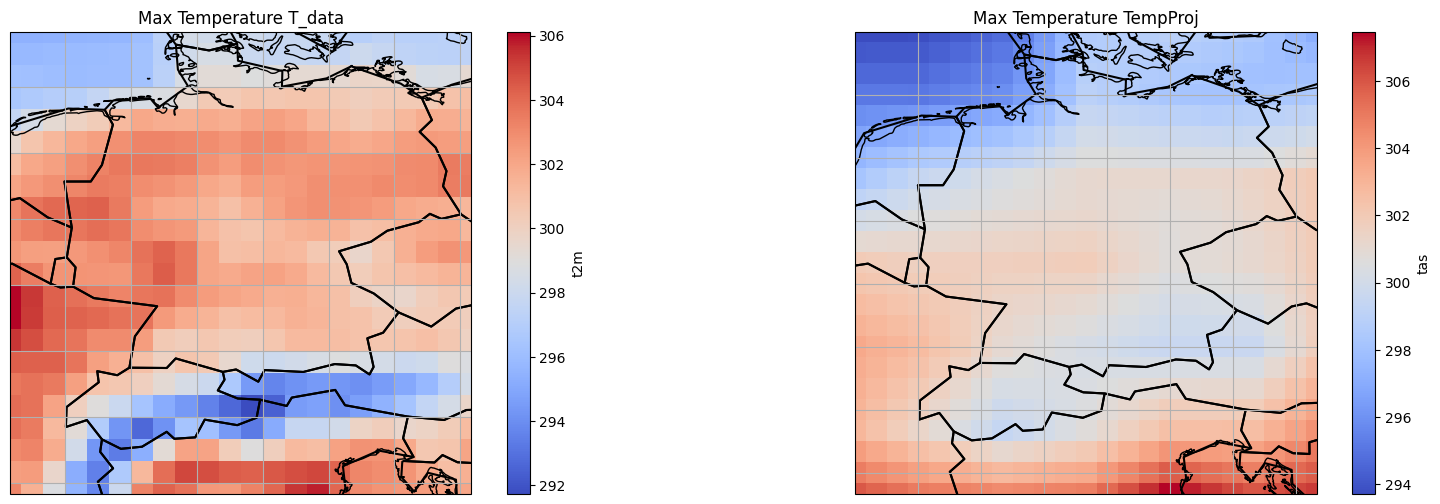

In [169]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_T_data = [
    T_data.lon.min(),
    T_data.lon.max(),
    T_data.lat.min(),
    T_data.lat.max()
]

extent_TempProj_clipped = [
    TempProj_clipped.x.min(),
    TempProj_clipped.x.max(),
    TempProj_clipped.y.min(),
    TempProj_clipped.y.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for T_data
T_data.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_T_data)
ax1.set_title('Max Temperature T_data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_clipped.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_clipped)
ax2.set_title('Max Temperature TempProj')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


In [170]:
TempProj_interp = TempProj_clipped.rename({'x': 'lon', 'y': 'lat'})

TempProj_interp = TempProj_interp.interp(
    lon=T_data.lon,
    lat=T_data.lat,
    method='linear'
)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1839751751.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


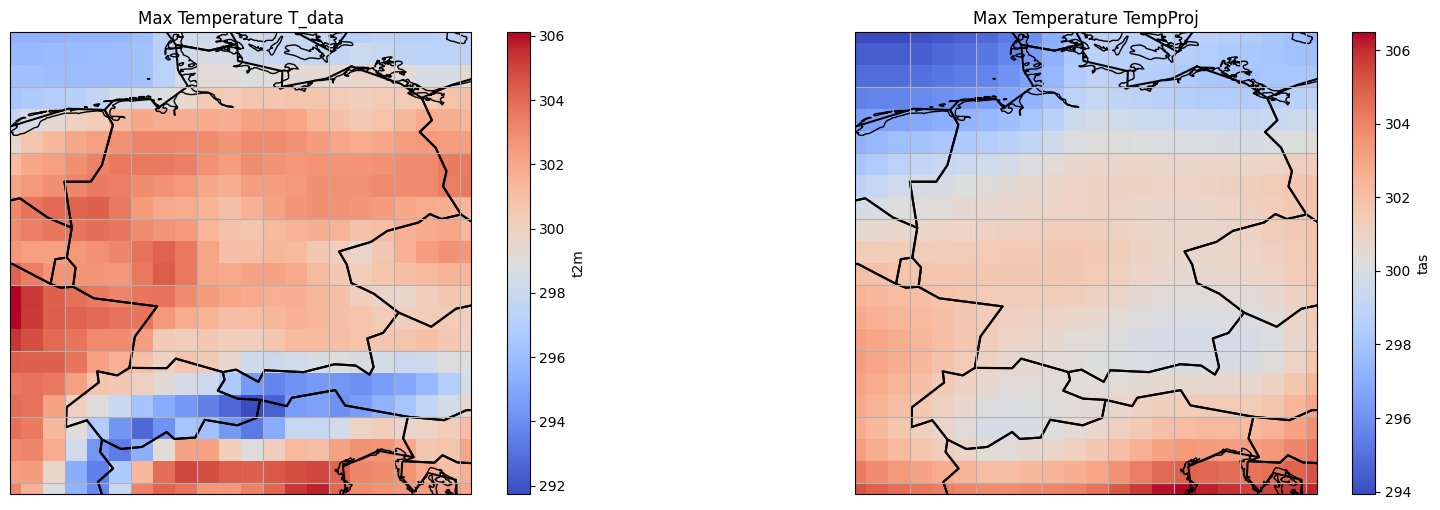

In [173]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_T_data = [
    T_data.lon.min(),
    T_data.lon.max(),
    T_data.lat.min(),
    T_data.lat.max()
]

extent_TempProj_clipped = [
    TempProj_interp.lon.min(),
    TempProj_interp.lon.max(),
    TempProj_interp.lat.min(),
    TempProj_interp.lat.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for T_data
T_data.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_T_data)
ax1.set_title('Max Temperature T_data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_interp.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_clipped)
ax2.set_title('Max Temperature TempProj')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1905263065.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


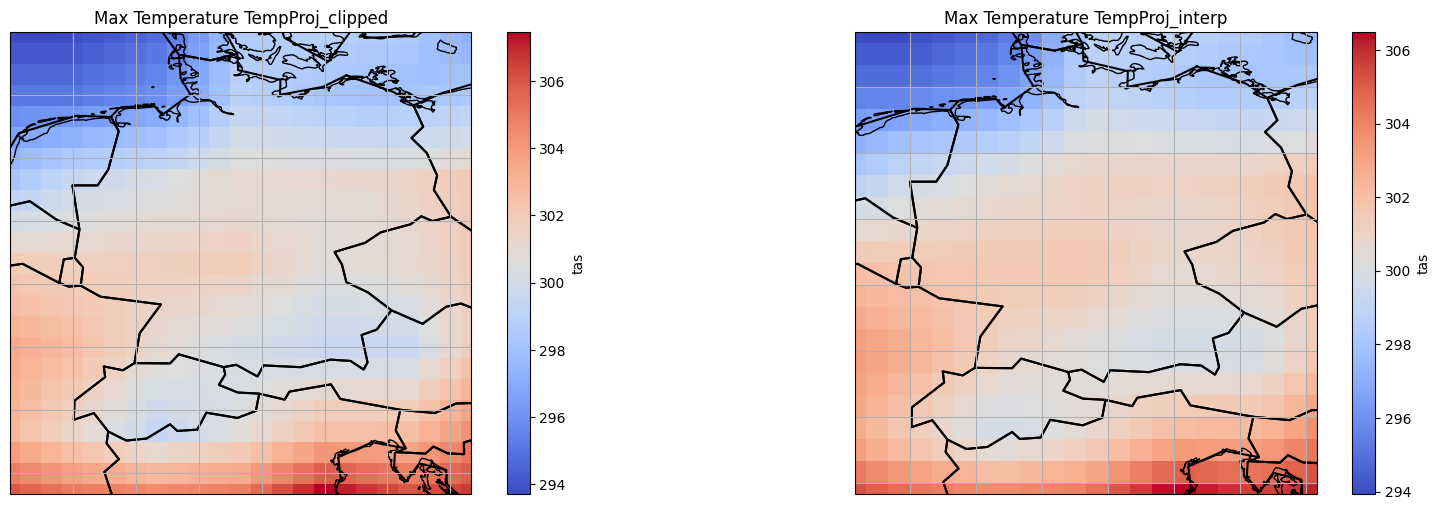

In [174]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_TempProj_clipped = [
    TempProj_clipped.x.min(),
    TempProj_clipped.x.max(),
    TempProj_clipped.y.min(),
    TempProj_clipped.y.max()
]

extent_TempProj_interp = [
    TempProj_interp.lon.min(),
    TempProj_interp.lon.max(),
    TempProj_interp.lat.min(),
    TempProj_interp.lat.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_clipped.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_TempProj_clipped)
ax1.set_title('Max Temperature TempProj_clipped')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_interp
TempProj_interp.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_interp)
ax2.set_title('Max Temperature TempProj_interp')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


# Offset


### Convert precipitation

In [20]:
# Convert precipitation to m/day (same unit as P_data)
PrecProj_interp_mm_day= PrecProj_interp * 86400 # to mm/day
PrecProj_interp_converted = PrecProj_interp_mm_day / 10**3 # to m/day

In [21]:
P_data

<xarray.DataArray 'tp' (time: 8766, lat: 22, lon: 22)> Size: 34MB
array([[[3.46481823e-03, 3.52501881e-03, 3.56233120e-03, ...,
         4.17888165e-03, 4.38153755e-03, 4.28330898e-03],
        [3.06499028e-03, 3.20494187e-03, 3.23843944e-03, ...,
         3.74197948e-03, 4.00769734e-03, 4.01580334e-03],
        [2.55775452e-03, 2.78794760e-03, 2.93862820e-03, ...,
         3.16965580e-03, 3.32868111e-03, 3.28898442e-03],
        ...,
        [1.44159794e-03, 5.14626503e-04, 2.06112854e-04, ...,
         1.09434128e-04, 1.69992440e-04, 1.90138824e-04],
        [1.15823749e-03, 3.91721740e-04, 1.32083896e-04, ...,
         6.02006894e-05, 9.75131952e-05, 8.11815262e-05],
        [3.57389465e-04, 1.53064728e-04, 5.32865524e-05, ...,
         1.19209287e-06, 1.40666957e-05, 2.24113455e-05]],

       [[3.56435767e-05, 4.64916229e-05, 6.28232974e-05, ...,
         5.32031045e-04, 6.32882104e-04, 5.45144052e-04],
        [6.79492950e-05, 8.40425491e-05, 1.23500828e-04, ...,
         6.38246565e-04, 7.19785719e-04, 8.15153093e-04],
        [1.26481053e-04, 1.95622444e-04, 3.13878067e-04, ...,
         8.63790570e-04, 8.28862219e-04, 7.08341628e-04],
...
        [1.07288361e-06, 2.74181360e-06, 6.07967377e-05, ...,
         3.96370902e-04, 1.98125839e-04, 1.22785564e-05],
        [2.67028799e-05, 2.50339508e-06, 2.38418586e-07, ...,
         1.37758255e-03, 1.57344335e-03, 7.04526901e-04],
        [1.67846683e-04, 2.44379025e-05, 4.29153442e-06, ...,
         1.70743471e-03, 2.53236294e-03, 1.71363348e-03]],

       [[6.35933876e-03, 6.17563748e-03, 6.88850926e-03, ...,
         6.12592720e-03, 4.64487076e-03, 2.97474861e-03],
        [8.04340839e-03, 7.68363476e-03, 7.49313855e-03, ...,
         4.70542931e-03, 4.50348831e-03, 3.74472141e-03],
        [1.03950505e-02, 9.75692295e-03, 7.82287144e-03, ...,
         2.90024275e-03, 3.01516056e-03, 2.95066810e-03],
        ...,
        [4.17673588e-03, 6.37078285e-03, 9.34886886e-03, ...,
         1.34382248e-02, 7.94792175e-03, 2.26140028e-03],
        [4.75358963e-03, 5.86473942e-03, 8.82864045e-03, ...,
         1.38142104e-02, 1.05863807e-02, 2.54297251e-03],
        [5.23793686e-03, 4.76324558e-03, 7.86876655e-03, ...,
         9.08184028e-03, 7.43615627e-03, 3.19671608e-03]]])
Coordinates:
  * lon      (lon) float64 176B 4.75 5.25 5.75 6.25 ... 13.75 14.25 14.75 15.25
  * lat      (lat) float64 176B 55.25 54.75 54.25 53.75 ... 45.75 45.25 44.75
  * time     (time) datetime64[ns] 70kB 2000-01-01 2000-01-02 ... 2023-12-31
Attributes:
    long_name:          Total precipitation
    units:              m
    standard_name:      lwe_thickness_of_precipitation_amount
    comment:            The construction lwe_thickness_of_X_amount or _conten...
    type:               real
    accumulated_since:  start of timestep

In [23]:
print(P_data.min().values)
print(P_data.mean().values)
print(P_data.max().values)

0.0
0.0028199790804698407
0.13114094361662865


In [26]:
print(PrecProj_interp.min().values)
print(PrecProj_interp.mean().values)
print(PrecProj_interp.max().values)

7.511065973631048e-07
2.8921808252561782e-05
9.962969306798186e-05


In [37]:
print(PrecProj_interp.min().values)
print(PrecProj_interp.mean().values)
print(PrecProj_interp.max().values)

7.511065973631048e-07
2.8921808252561782e-05
9.962969306798186e-05


In [24]:
print(PrecProj_interp_converted.min().values)
print(PrecProj_interp_converted.mean().values)
print(PrecProj_interp_converted.max().values)

6.489561001217225e-05
0.0024988442330213375
0.008608005481073632


In [22]:
PrecProj_interp_converted

<xarray.DataArray 'pr' (time: 1212, lat: 22, lon: 22)> Size: 5MB
array([[[0.00318027, 0.00323556, 0.00329105, ..., 0.00223417,
         0.00217316, 0.00211214],
        [0.00308781, 0.0031642 , 0.00324081, ..., 0.00223976,
         0.00219485, 0.00214991],
        [0.00299555, 0.00309299, 0.00319062, ..., 0.00224529,
         0.00221634, 0.00218747],
        ...,
        [0.00370661, 0.00409361, 0.004483  , ..., 0.00197172,
         0.00194519, 0.00191909],
        [0.0033209 , 0.0036302 , 0.00394189, ..., 0.00187409,
         0.00190937, 0.00194506],
        [0.00293522, 0.00316684, 0.00340083, ..., 0.00177647,
         0.00187355, 0.00197104]],

       [[0.00284001, 0.00285667, 0.0028738 , ..., 0.0019336 ,
         0.00192258, 0.00191158],
        [0.00270379, 0.00272957, 0.00275584, ..., 0.0019314 ,
         0.00192834, 0.00192529],
        [0.00256803, 0.00260299, 0.00263811, ..., 0.00192925,
         0.00193416, 0.00193902],
...
        [0.00186926, 0.00205476, 0.00224095, ..., 0.00146439,
         0.00142354, 0.0013831 ],
        [0.00178754, 0.00193727, 0.00208769, ..., 0.00137267,
         0.0013824 , 0.00139254],
        [0.00170582, 0.00181979, 0.00193443, ..., 0.00128095,
         0.00134127, 0.00140198]],

       [[0.0043601 , 0.00441646, 0.00447282, ..., 0.0031332 ,
         0.00320582, 0.00327767],
        [0.00434281, 0.00440772, 0.00447264, ..., 0.00332234,
         0.00340522, 0.0034873 ],
        [0.00432578, 0.00439921, 0.00447254, ..., 0.00351109,
         0.0036036 , 0.00369583],
        ...,
        [0.00441103, 0.00486734, 0.00532543, ..., 0.00351472,
         0.00326811, 0.0030227 ],
        [0.00410878, 0.00451599, 0.00492499, ..., 0.00324259,
         0.00315445, 0.00306749],
        [0.00380655, 0.00416468, 0.00452459, ..., 0.00297048,
         0.00304079, 0.00311229]]])
Coordinates:
  * time         (time) object 10kB 2000-01-15 12:00:00 ... 2100-12-15 12:00:00
    spatial_ref  int64 8B 0
  * lon          (lon) float64 176B 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25
  * lat          (lat) float64 176B 55.25 54.75 54.25 ... 45.75 45.25 44.75

## Temp, Rad, LAI, Prec

In [257]:
TempProj_corrected = func.correct_temporal_bias(TempProj_interp, T_data)

RadProj_converted = RadProj_interp * 86400
RadProj_corrected = func.correct_temporal_bias(RadProj_converted, R_data)

LaiProj_corrected = func.correct_temporal_bias(LaiProj_interp, lai_data)

Mean Difference Over All Pixels: 1.2781354487976833


In [ ]:
PrecProj_corrected = func.correct_temporal_bias(PrecProj_interp, P_data)

In [430]:
TempProj_corrected.to_netcdf('data/projections/Temperature_2000_2100_cropped_offset.nc')
PrecProj_corrected.to_netcdf('data/projections/Precipitation_2000_2100_cropped_offset.nc')
LaiProj_corrected.to_netcdf('data/projections/LeafAreaIndex_2000_2100_cropped_offset.nc')
RadProj_corrected.to_netcdf('data/projections/RadiationRLS_2000_2100_cropped_offset.nc')

# Create daily data

## Temperature (long)

In [4]:
# neu einladen
lai_future = xr.open_dataarray("data/projections/LeafAreaIndex_2000_2100_cropeed_offset.nc")
T_future = xr.open_dataarray("data/projections/Temperature_2000_2100_cropped_offset.nc")
R_future = xr.open_dataarray("data/projections/RadiationRLS_2000_2100_cropeed_offset.nc")
P_future = xr.open_dataarray("data/projections/Precipitation_2000_2100_cropped_offset.nc")

In [361]:
T_future

<xarray.DataArray 'tas' (time: 1212, lat: 22, lon: 22)> Size: 5MB
[586608 values with dtype=float64]
Coordinates:
  * time         (time) object 10kB 2000-01-15 12:00:00 ... 2100-12-15 12:00:00
    spatial_ref  int64 8B ...
  * lon          (lon) float64 176B 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25
  * lat          (lat) float64 176B 55.25 54.75 54.25 ... 45.75 45.25 44.75

In [407]:
new_time_range = pd.date_range(start='2000-01-01', end='2100-12-31', freq = 'M')
T_future['time'] = new_time_range
len(new_time_range)

1212

In [369]:
time_index = pd.to_datetime(T_future.time.values)
days_in_month = pd.DatetimeIndex(time_index).days_in_month
print(time_index)
print(days_in_month)

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2100-03-31', '2100-04-30', '2100-05-31', '2100-06-30',
               '2100-07-31', '2100-08-31', '2100-09-30', '2100-10-31',
               '2100-11-30', '2100-12-31'],
              dtype='datetime64[ns]', length=1212, freq=None)
Index([31, 29, 31, 30, 31, 30, 31, 31, 30, 31,
       ...
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
      dtype='int32', length=1212)


In [390]:
daily_dates = []

# Iterate through each month and generate daily dates
for idx, num_days in enumerate(days_in_month):
    # Get the start date of the month
    start_date = time_index[idx] - pd.offsets.MonthBegin(1)
    # For the first month, start from the first day of January
    if idx == 0:
        start_date = start_date.replace(day=1)
    # Create daily DateTimeIndex for the month
    month_dates = pd.date_range(start=start_date, periods=num_days, freq='D')
    # Append to the list of daily dates
    daily_dates.extend(month_dates)

In [413]:
daily_dates_index = pd.DatetimeIndex(daily_dates)
T_future_daily = np.repeat(T_future, days_in_month, axis=0)

In [415]:
T_future_daily['time'] = daily_dates_index

## P, R, LAI

Use the new function to do the same for P, R, LAI:

In [424]:
P_future_daily = func.create_daily_timesteps(P_future)

In [426]:
lai_future_daily = func.create_daily_timesteps(lai_future)

In [427]:
R_future_daily = func.create_daily_timesteps(R_future)

I have these on my computer locally, because they are too big for github

In [431]:
#T_future_daily.to_netcdf('data/projections/Temperature_2000_2100_cropped_offset_daily.nc')
#P_future_daily.to_netcdf('data/projections/Precipitation_2000_2100_cropped_offset_daily.nc')
#lai_future_daily.to_netcdf('data/projections/LeafAreaIndex_2000_2100_cropped_offset_daily.nc')
#R_future_daily.to_netcdf('data/projections/RadiationRLS_2000_2100_cropped_offset_daily.nc')

Test whether the temperature is the same for every day in a month

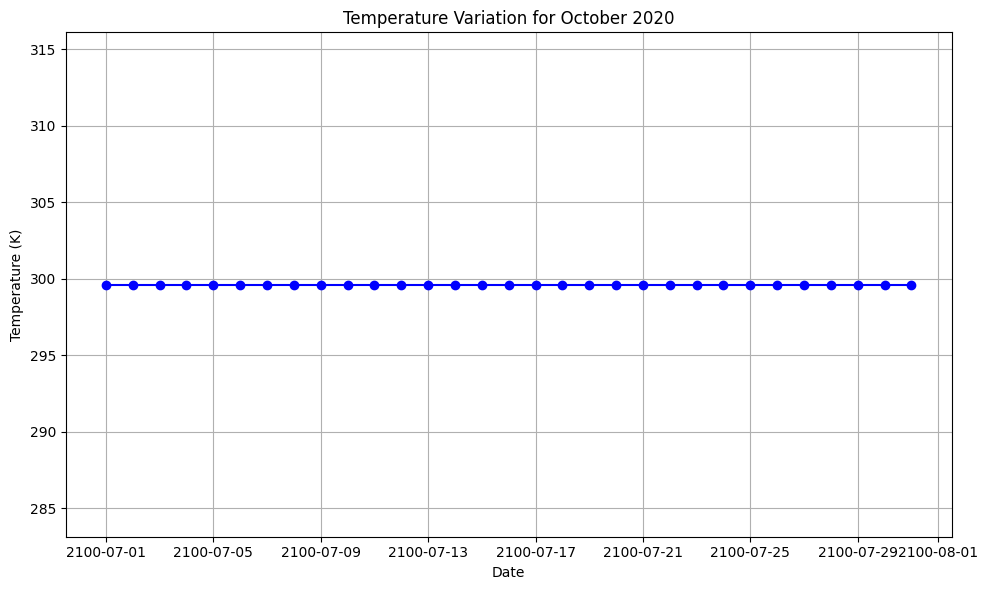

In [454]:
# Extract temperature data for one pixel (e.g., latitude_index, longitude_index)
temperature_data = T_future_daily[:, 18, 18]

# Convert to DataFrame for easier manipulation
df = temperature_data.to_dataframe(name='temperature')

# Filter data for October 2020 and for one year
october_2020_data = df[(df.index.year == 2100) & (df.index.month == 7)]

# Plot the temperature variation for October 2020
plt.figure(figsize=(10, 6))
plt.plot(october_2020_data.index, october_2020_data['temperature'], color='blue', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
plt.title('Temperature Variation for October 2020')
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily values with STD

In [12]:
T_future_daily = xr.open_dataarray('/Volumes/Camtasia/projections/daily/Temperature_2000_2100_cropped_offset_daily.nc')
R_future_daily = xr.open_dataarray('/Volumes/Camtasia/projections/daily/RadiationRLS_2000_2100_cropped_offset_daily.nc')
lai_future_daily = xr.open_dataarray('/Volumes/Camtasia/projections/daily/LeafAreaIndex_2000_2100_cropped_offset_daily.nc')
P_future_daily = xr.open_dataarray('/Volumes/Camtasia/projections/daily/Precipitation_2000_2100_cropped_offset_daily.nc')

## Temperature (long)

1. Get standard deviation from forcing data

In [1]:
std_dev = T_data.groupby('time.month').std()

NameError: name 'T_data' is not defined

In [15]:
# runtime: 6 minutes
T_future_daily_variation = T_future_daily.groupby('time').apply(func.add_daily_variation)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_10596/313027918.py:1: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  T_future_daily_variation = T_future_daily.groupby('time').apply(add_daily_variation)


Check:

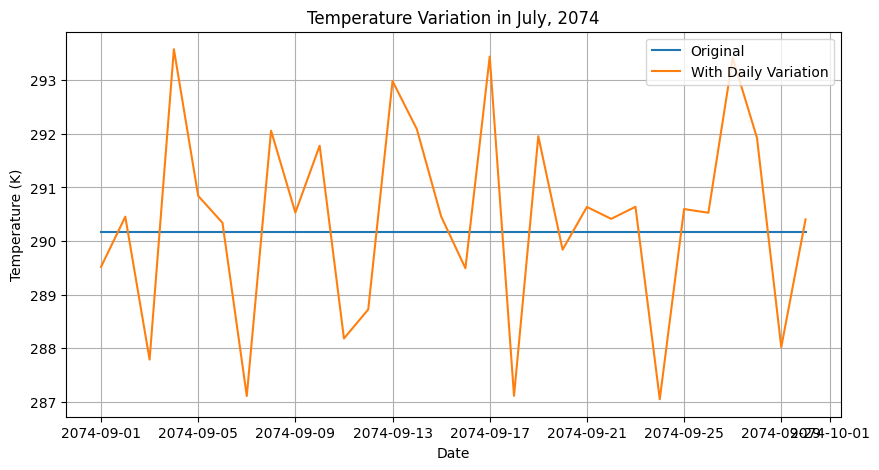

In [16]:
year = 2074
month = 9  # July
start_date = f"{year}-{month:02d}-01"
end_date = f"{year}-{month:02d}-30"

T_future_daily_original_month = T_future_daily.sel(time=slice(start_date, end_date))
T_future_daily_variation_month = T_future_daily_variation.sel(time=slice(start_date, end_date))


# Plot original and modified datasets for one month
plt.figure(figsize=(10, 5))
plt.plot(T_future_daily_original_month.time, T_future_daily_original_month.sel(lat=54.25, lon=5.75), label='Original')
plt.plot(T_future_daily_variation_month.time, T_future_daily_variation_month.sel(lat=54.25, lon=5.75), label='With Daily Variation')
plt.title('Temperature Variation in July, {}'.format(year))
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid(True)
plt.show()

## Function for P, R, lai

In [17]:
std_dev = P_data.groupby('time.month').std()

In [18]:
# precipitation - runtime: 6 min
std_dev = P_data.groupby('time.month').std()
P_future_daily_variation = P_future_daily.groupby('time').apply(func.add_daily_variation)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_10596/1598032604.py:3: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  P_future_daily_variation = P_future_daily.groupby('time').apply(add_daily_variation)


In [19]:
# lai - runtime: 5 min
std_dev = lai_data.groupby('time.month').std()
Lai_future_daily_variation = lai_future_daily.groupby('time').apply(func.add_daily_variation)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_10596/4081714152.py:3: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  Lai_future_daily_variation = lai_future_daily.groupby('time').apply(add_daily_variation)


In [23]:
# raditaiton 
std_dev = R_data.groupby('time.month').std()
R_future_daily_variation = R_future_daily.groupby('time').apply(func.add_daily_variation)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_10596/3744869713.py:3: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  R_future_daily_variation = R_future_daily.groupby('time').apply(add_daily_variation)


In [21]:
T_future_daily_variation.to_netcdf('/Volumes/Camtasia/projections/daily_var/Temperature_2000_2100_cropped_offset_daily_variation.nc')
P_future_daily_variation.to_netcdf('/Volumes/Camtasia/projections/daily_var/Precipitation_2000_2100_cropped_offset_daily_variation.nc')
Lai_future_daily_variation.to_netcdf('/Volumes/Camtasia/projections/daily_var/LeafAreaIndex_2000_2100_cropped_offset_daily_variation.nc')

NameError: name 'lai_future_daily_variation' is not defined

In [24]:
R_future_daily_variation.to_netcdf('/Volumes/Camtasia/projections/daily_var/RadiationRLS_2000_2100_cropped_offset_daily_variation.nc')

# Precipitation

In [35]:
P_future_daily_variation = xr.open_dataarray('/Volumes/Camtasia/projections/daily_var/Precipitation_2000_2100_cropped_offset_daily_variation.nc')

* P_data is in m/day and then converted to mm/day in the time evolution function
* that means if I convert my daily values in T_future_daily to m/day I will end up with usable values for the model

<br> 

* to convert data from kg/km2/s to mm/day calculate * 86400 (seconds per day)
* from mm/day to m/day /1000 <br>

--> T_future_daily * 86 400 / 1000 <br>

BUT I need to do this before the offset! 

In [32]:
P_converted = P_future * 86400 / 1000

In [33]:
P_converted

<xarray.DataArray 'pr' (time: 1212, lat: 22, lon: 22)> Size: 5MB
array([[[0.24430776, 0.24436304, 0.24441853, ..., 0.24336165,
         0.24330065, 0.24323963],
        [0.24421529, 0.24429169, 0.2443683 , ..., 0.24336725,
         0.24332233, 0.24327739],
        [0.24412303, 0.24422048, 0.2443181 , ..., 0.24337277,
         0.24334383, 0.24331495],
        ...,
        [0.24483409, 0.24522109, 0.24561048, ..., 0.2430992 ,
         0.24307267, 0.24304657],
        [0.24444838, 0.24475769, 0.24506938, ..., 0.24300158,
         0.24303685, 0.24307255],
        [0.24406271, 0.24429432, 0.24452832, ..., 0.24290396,
         0.24300103, 0.24309852]],

       [[0.2439675 , 0.24398415, 0.24400129, ..., 0.24306108,
         0.24305007, 0.24303907],
        [0.24383127, 0.24385706, 0.24388333, ..., 0.24305889,
         0.24305583, 0.24305278],
        [0.24369552, 0.24373048, 0.24376559, ..., 0.24305673,
         0.24306165, 0.2430665 ],
...
        [0.24299675, 0.24318225, 0.24336843, ..., 0.24259188,
         0.24255103, 0.24251058],
        [0.24291502, 0.24306476, 0.24321517, ..., 0.24250015,
         0.24250989, 0.24252002],
        [0.24283331, 0.24294728, 0.24306192, ..., 0.24240844,
         0.24246875, 0.24252946]],

       [[0.24548759, 0.24554394, 0.24560031, ..., 0.24426068,
         0.24433331, 0.24440516],
        [0.2454703 , 0.24553521, 0.24560012, ..., 0.24444983,
         0.2445327 , 0.24461479],
        [0.24545326, 0.24552669, 0.24560002, ..., 0.24463858,
         0.24473109, 0.24482332],
        ...,
        [0.24553851, 0.24599482, 0.24645291, ..., 0.24464221,
         0.24439559, 0.24415018],
        [0.24523626, 0.24564348, 0.24605248, ..., 0.24437008,
         0.24428193, 0.24419498],
        [0.24493404, 0.24529217, 0.24565207, ..., 0.24409797,
         0.24416828, 0.24423977]]])
Coordinates:
  * time         (time) object 10kB 2000-01-15 12:00:00 ... 2100-12-15 12:00:00
    spatial_ref  int64 8B ...
  * lon          (lon) float64 176B 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25
  * lat          (lat) float64 176B 55.25 54.75 54.25 ... 45.75 45.25 44.75